# TPOT-NN
## Evaluation jobs meta results
Written and coded by Joseph D. Romano, PhD.

This notebook aggregates the pipelines resulting from all evaluation runs of TPOT-NN. Primarily, the goals are to establish:

1. The performance of the new NN models on 9 datasets
2. When/if TPOT-NN models outperform existing (shallow) models
3. The time difference in training TPOT-NN vs. TPOT shallow models
4. Specifically, whether shallow models (e.g., pytorch LR) plus feature selection reach or exceed the performance of deep models
5. How(/if) TPOT preferentially uses NN models when GP is allowed (e.g., does it stack multiple LR/MLP when we allow it to do so?)

- - -

### Datasets:

We're performing the evaluations on the same 9 classification datasets used in the 'original' TPOT publication (https://dl.acm.org/doi/10.1145/2908812.2908918). These are:

| Dataset | Num. instances | Num. features | Feature type(s) | Classes | Real/Synthetic |
|---------|----------------|---------------|-----------------|---------|----------------|
| Hill_Valley_with_noise | 1212 | 100 | Float ($> 0$) | 2 (binary) | synthetic |
| Hill_Valley_without_noise | 1212 | 100 | Float ($> 0$) | 2 (binary) | synthetic |
| breast-cancer-wisconsin | 569 | 30 | Float ($\geq 0$) | 2 (binary) | real |
| car-evaluation | 1728 | 21 | Binary (one-hot) | 4 (0-3) | real(?) |
| glass | 205 | 9 | Float ($\geq 0$) | 7 (1-7) | real |
| ionosphere | 351 | 34 | Mixed (2 binary, 32 float) | 2 (binary) | real |
| spambase | 4601 | 57 | Mixed (2 int, 55 float) | 2 (binary) | real |
| wine-quality-red | 1599 | 11 | Float | 10 (not all observed) | real |
| wine-quality-white | 4893 | 11 | Float | 10 (not all observed) | real |

- - -
### Utility functions and imports

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import glob
import re
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
dset_str_map = {
    'hillvalleywithnoise': 'Hill_Valley_with_noise',
    'hillvalleywithoutnoise': 'Hill_Valley_without_noise',
    'breastcancerwisconsin': 'breast-cancer-wisconsin',
    'carevaluation': 'car-evaluation',
    'glass': 'glass',
    'ionosphere': 'ionosphere',
    'spambase': 'spambase',
    'winequalityred': 'wine-quality-red',
    'winequalitywhite': 'wine-quality-white'
}

def parse_pipeline_filename(fname):
    no_path = fname.split("/")[-1]
    # Example: 'tpot-nn_all_nn_nosolo_config_spambase_rep3_1583952116.py'
    parts = no_path.split('.')[0].split('_')[1:]
    # Example: ['all', 'nn', 'nosolo', 'config', 'spambase', 'rep3', '1583952116']
    return {
        'models': parts[0],
        'nn_enabled': (lambda x: True if x == 'nn' else False)(parts[1]),
        'classifier_only': (lambda x: True if x == 'solo' else False)(parts[2]),
        'uses_template': (lambda x: True if x == 'template' else False)(parts[3]),
        'database': dset_str_map[parts[4]],
        'rep_number': parts[5].split('rep')[-1],
        'submission_time': datetime.fromtimestamp(int(parts[6])),
        'file_name': fname
    }

pipelines = []
for f in glob.glob("../pipelines/*"):
    pipelines.append(parse_pipeline_filename(f))
job_metadata = pd.DataFrame(pipelines)

def run_saved_pipeline(single_job_metadata):
    """Until refactor, the only 'result' this function provides is that it returns
    the CV score for the pipeline specified.
    """
    xx = single_job_metadata

    with open(xx['file_name'], 'r') as fp:
        x = fp.readlines()

    new_job_string = ['from pmlb import fetch_data\n']
    for l in x:
        if re.search('PATH/TO/DATA/FILE', l):
            new_job_string.append("tpot_data = fetch_data('{0}')\n".format(xx['database']))
        else:
            new_job_string.append(l)
        if re.search('Average CV score', l):
            score = float(l.split(' ')[-1].strip())

    job_string_join = ''.join(new_job_string)
    # use `exec(job_string_join)` to run the pipeline
    #exported_pipeline = exec(job_string_join)
    return(score)

cv_scores = [run_saved_pipeline(x) for i, x in job_metadata.iterrows()]
job_metadata.insert(6, 'cv_score', cv_scores)

In [3]:
job_metadata

,models,nn_enabled,classifier_only,uses_template,database,rep_number,cv_score,submission_time,file_name
0,lr,False,False,False,breast-cancer-wisconsin,5,0.993407,2020-03-18 15:00:28,../pipelines/tpot-nn_lr_no-nn_nosolo_config_br...
1,mlp,True,True,False,spambase,3,0.936141,2020-03-18 15:00:51,../pipelines/tpot-nn_mlp_nn_solo_config_spamba...
2,all,True,False,False,Hill_Valley_with_noise,2,1.000000,2020-03-18 15:00:06,../pipelines/tpot-nn_all_nn_nosolo_config_hill...
3,lr,True,True,False,breast-cancer-wisconsin,3,0.936264,2020-03-18 15:00:22,../pipelines/tpot-nn_lr_nn_solo_config_breastc...
4,mlp,False,True,False,Hill_Valley_with_noise,4,0.907104,2020-03-18 15:00:07,../pipelines/tpot-nn_mlp_no-nn_solo_config_hil...
...,...,...,...,...,...,...,...,...,...
303,mlp,True,True,False,ionosphere,4,0.928571,2020-03-18 15:00:44,../pipelines/tpot-nn_mlp_nn_solo_config_ionosp...
304,mlp,False,False,True,spambase,5,0.948370,2020-03-18 15:00:55,../pipelines/tpot-nn_mlp_no-nn_nosolo_template...
305,lr,True,False,True,ionosphere,1,0.967857,2020-03-18 15:00:45,../pipelines/tpot-nn_lr_nn_nosolo_template_ion...
306,lr,True,False,False,ionosphere,5,0.964286,2020-03-18 15:00:46,../pipelines/tpot-nn_lr_nn_nosolo_config_ionos...


- - -
## Performance of new TPOT-NN models on all 9 datasets

In [4]:
pytorch_lr_pipelines = job_metadata.loc[(job_metadata.models == 'lr') & (job_metadata.nn_enabled == True),:]
pytorch_mlp_pipelines = job_metadata.loc[(job_metadata.models == 'mlp') & (job_metadata.nn_enabled == True),:]

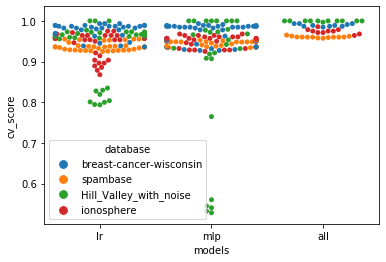

In [5]:
sns.swarmplot(x="models", y="cv_score", hue="database", data=job_metadata)